## Introduction

Based on: https://github.com/seg/2016-ml-contest. Co-ordinated by Matt Hall
Following Brendon Hall's tutorial in the leading edge.

A question to consider at the start of a data science exercise is "can this problem be solved by an experienced human?". From a geoscience background, the initial hunch is no. This is also reflected in the moderate scores, no team has over 65% yet. 

We want to define a function y = h(X) 
Where y is originaly based on y = h(U)
Where: h(U) is a geological interpretation of core data and will not be reproducible in this experiment. It is not assured that y can be predicted based only on these well logs.

This evaluation investigated this idea and consider what could be done to allow for a higher score. It followed:

1. Consider if the problem can be answered.
2. Exploratory data analysis.
3. Test a simple model.
4. Select base models based on testing models with different parameters.
5. Engineer extra features and optimize.

###### Mistakes made along the way
1. Trained model on cross validated data then refit best parameters on all data, appears to have led to overfitting, specifically on facies 9. = 0.44, 0.54 with facies 9 converted to 8 manually.
2. Tested for why facies 9 seemed to dominate, appears to be overfitting F9 with different models and different approaches. OneVsOne may be key to stopping F9 dominating the prediction. Removed F9 entirely to try to create a base model before trying feature engineering. Led to a 0.552 test. This seems a good attempt before adding more sophisticated feature engineering, trainnig score is only 0.45.
3. Feature engineering. Still have not cross-referenced the same method with OneVsOne because XGB boost gives errors that have not been fixed when attempting to use in OneVsOne.

#### Conclusions
The results suggest that there is significant overlap in the wireline well log responses for a number of facies. That even with feature engineering it can be difficult to differentiate. It is beyond the scope of this submission to discuss the geological and petrophysical reasons for this. One key example is non-marine coarse siltstone vs. non-marine fine siltstone, this produces the most errors of all models tested. Even in core these two can be challenging to interpret. Perhaps gouping into one non-marine siltstone would be more suitable for a modelling exercise.

The learning curves and other QC plots do not seem to suggest that obtaining more data will neccisarily make this better as they all flatten out early. The main problem here is recall. Either the question should be reconfigured to ask for rock property groups that can be defined by a petrophysicist or a greater variety of well logs should be used. E.g. spectral gamma ray.

A score around 90-95% may be needed to give confidence to be implemented in a producing field. The conclusions for this evaluation is that the experimental design needs to changed to be able to achieve this. This competition and the original paper has been a fantastic way to start a discussion within the geoscience community around machine learning, the lower scores appear to be a limitation of this specific challenge rather than the machine learning methodology.

##### Initializing

In [48]:
#     Initializing

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
import seaborn as sns

#Enable inline plotting
%matplotlib inline

print ("This has been run using:")
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + matplotlib.__version__)

## Set colour template
sns.set(style="ticks")    ## Set style to white background and ticks
sns.set_context("paper")   ## Set size of labels

#     Load file
try:
    print("Loading dataset...")
    CSV_Dataset = r"facies_vectors.csv"
    Dataset = pd.read_csv(CSV_Dataset)
except:
    print ("An error has occured")
    print ("Please ensure that you have downloaded the dataset and")
    print ("entered the file location and file path for your machine")
finally:
    print ("Expected input is the file facies_vectors.csv")

Dataset.head()

## Remove Recruit F9
Dataset = Dataset[Dataset["Well Name"] != "Recruit F9"]

This has been run using:
Python version 3.5.2 |Anaconda custom (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
Pandas version 0.19.1
Matplotlib version 1.5.3
Loading dataset...
Expected input is the file facies_vectors.csv


## Step 2: Checking the data and view facies

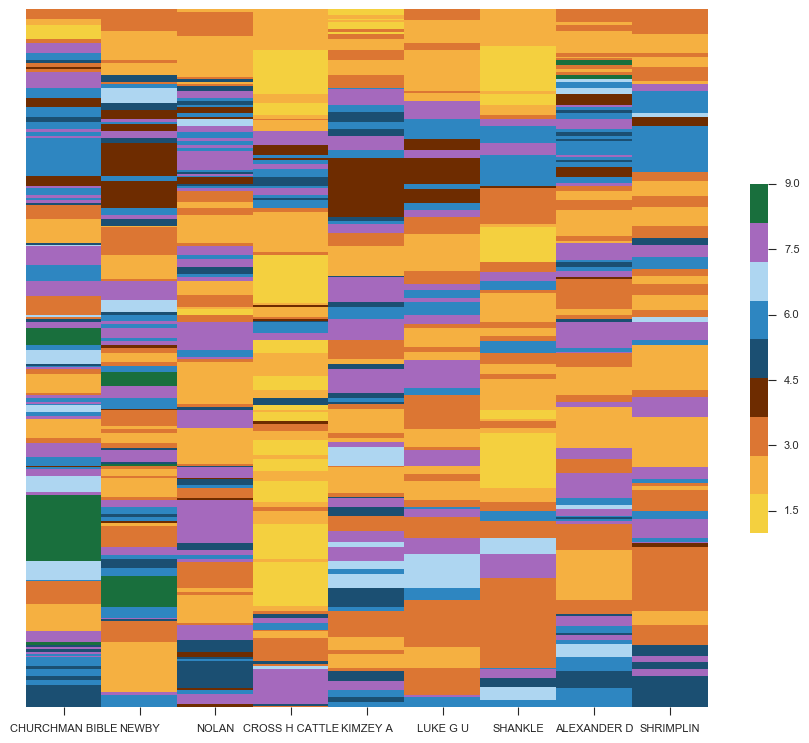

In [59]:
#### Make a new array  that consists of the facies organised in columns for each well
Facies_Plot = Dataset.iloc[:,0]
Well = Dataset.iloc[:,2]

Facies_Plot = pd.concat([Facies_Plot, Well], axis=1)
grouped = Facies_Plot.groupby('Well Name')
Facies_Plot = Facies_Plot.rename(columns = {"Well Name":"Well_Name"}) # To be able to use the header in the .unique method
List = Facies_Plot.Well_Name.unique()

u = np.arange(501)  #make a dummy key based on the legth of the longest well - Should be automated.
b = pd.DataFrame()
b["key"]=u

for i in List:
    a = grouped.get_group(i)
    a = a.rename(columns = {"Facies":i})
    a = a.drop("Well Name", 1)
    [c, d] = a.shape
    e = np.arange(c)
    a["key"]=e
    #b = pd.concat([a, b], axis=1)
    b = pd.merge(a, b, on='key')
Facies_Plot = b
Facies_Plot = Facies_Plot.drop("key", 1)

cmap_facies = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
from matplotlib.colors import ListedColormap
cmap_list = ListedColormap(cmap_facies)

## Plot all facies to give a visual impression of the distribution of facies
f, ax = plt.subplots(figsize=(11, 9))
ax = sns.heatmap(Facies_Plot, yticklabels=False, cmap=cmap_list, linewidths=0, vmin=1, vmax=9, ax=ax, cbar_kws={"shrink": .5})

###### Make new classes, X, y and dataframe for visualisations

In [45]:
### Create new categories ####

ytemp= Dataset.iloc[:,0]

def create_category(facies_names, y):
    a = 1
    for i in facies_names:
        y = y.replace(to_replace=a,value=i)
        a+=1
    return y

##Relable numerics with String label
ytemp_1=ytemp
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']

ytemp_1=create_category(facies_names, ytemp_1)

## Make a new column of depositional environments
ytemp_2=ytemp    
ytemp_2 = ytemp_2.rename(columns = {"Facies":"Dep Environment"})
facies_names = ['Clastic Non-marine', 'Clastic Non-marine', 'Clastic Non-marine', 'Clastic Non-marine', 'Clastic Marine', 'Carb Platform', 'Carb Platform', 'Carb Platform', 'Carb Platform']

ytemp_2=create_category(facies_names, ytemp_2)

## Make a new column of clastic vs. carbonate
ytemp_3=ytemp
ytemp_3.rename(columns={"Facies":"Lithology"}, inplace=True)
facies_names = ['Clastic', 'Clastic', 'Clastic', 'Clastic', 'Clastic', 'Carb', 'Carb', 'Carb', 'Carb']

ytemp_3=create_category(facies_names, ytemp_3)
    
## Make a new column of non-marine vs. marine
ytemp_4=ytemp
ytemp_4.rename(columns={"Facies":"Marine vs Non-marine"}, inplace=True)
facies_names = ['Non-marine', 'Non-marine', 'Non-marine', 'Marine', 'Marine', 'Marine', 'Marine', 'Marine', 'Marine']

ytemp_4=create_category(facies_names, ytemp_4)

## Merge the results into a new table
ytemp = pd.concat([ytemp_1, ytemp_2, ytemp_3, ytemp_4], axis=1)
ytemp.rename(columns={0:"Dep Environment"}, inplace=True)
ytemp.rename(columns={1:"Lithology"}, inplace=True)
ytemp.rename(columns={2:"M vs NM"}, inplace=True)
new_classes = ytemp

def prepare_X_Y(Dataset):
    ## Remove Recruit F9
    Dataset = Dataset[Dataset["Well Name"] != "Recruit F9"]
    Dataset = Dataset[Dataset["Facies"] != 9]

    print (Dataset.describe())
    ## Replace all missing values with the mean values
    Dataset = Dataset.fillna(Dataset.mean())

    ytemp = Dataset.iloc[:,0] #Note 0 index is used in python for the first position. 
    print (("m={0}").format(ytemp.shape))

    ## Keep the original version where all classifiers are stored in one columnn
    y_one_column = ytemp

    ## One hot vector for each valye of y. In case this is to be used as input for OneVsRest
    ## Get all the elements of y
    ySet = set(ytemp)
    Yn = len(ySet)

    # Each classifier should have a sperate column and be measured only in ones and zeros
    one_hot_y = ytemp
    y = pd.get_dummies(one_hot_y)
    y = y.rename(columns={1: "NM Coarse Sandstone", 2: "NM Coarse Siltstone", 3: "NM Fine Siltstone", 4:"Marine Siltstone", 5:"Mud Stone", 6:"Wacke Stone", 7:"Dolomite", 8:"Packe Stone", 9:"Baffle Stone"})
    
    [Dm , Dn] = Dataset.shape
    X = Dataset.iloc[:,1:Dn]  #where Dn is the number of columns in the original dataset
    
    ## X, y (One hot vector version), y (flat including intergers from 1-9).
    return X, y, y_one_column

X, y, y_one_column = prepare_X_Y(Dataset)

## Merge together new class labels, y results as one hot vecotr and X
df_full = pd.concat([new_classes, y, X], axis=1)
df = pd.concat([new_classes, X], axis=1)

            Facies        Depth           GR    ILD_log10     DeltaPHI  \
count  3964.000000  3964.000000  3964.000000  3964.000000  3964.000000   
mean      4.293391  2900.946393    65.925832     0.662245     4.560130   
std       2.328107   132.814458    30.012673     0.248731     5.275988   
min       1.000000  2573.500000    10.149000    -0.025949   -21.832000   
25%       2.000000  2816.000000    47.716750     0.502000     1.800000   
50%       3.000000  2926.500000    66.009500     0.639000     4.464500   
75%       6.000000  3000.000000    80.060750     0.823000     7.647250   
max       8.000000  3138.000000   361.150000     1.800000    19.312000   

             PHIND           PE         NM_M       RELPOS  
count  3964.000000  3071.000000  3964.000000  3964.000000  
mean     13.219628     3.642657     1.495964     0.524566  
std       7.237590     0.819939     0.500047     0.288699  
min       0.550000     0.200000     1.000000     0.000000  
25%       8.450000     3.100000  

## Plots to assess distribution of parameters

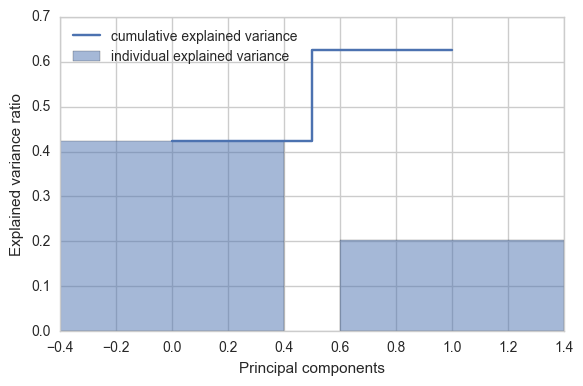

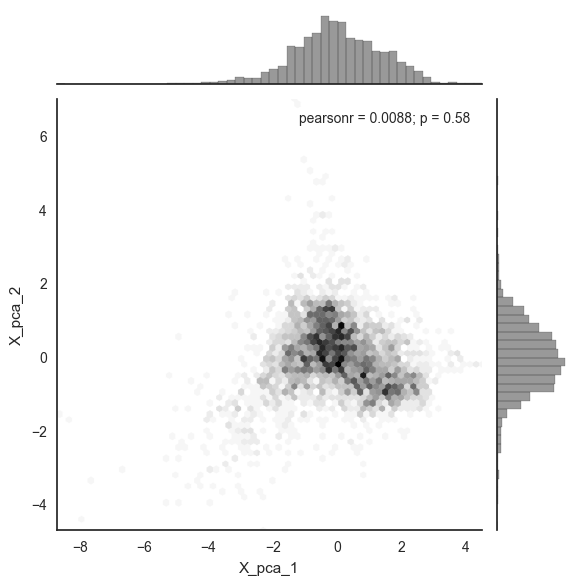

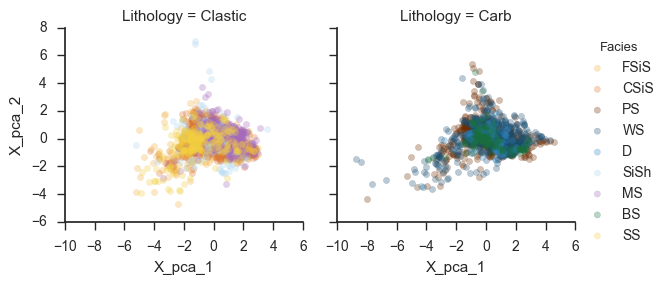

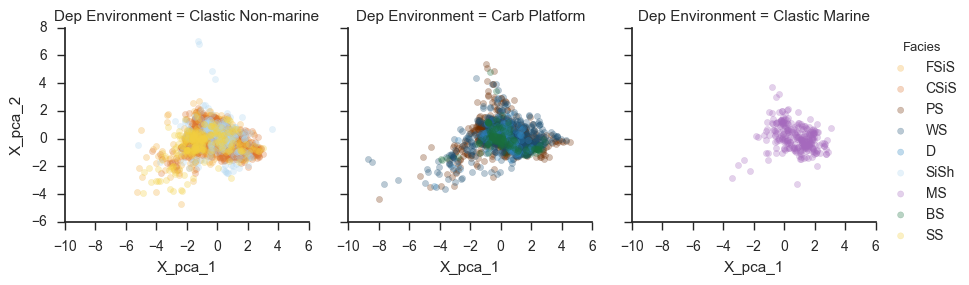

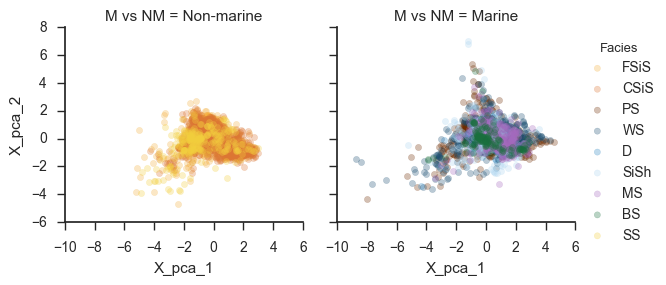

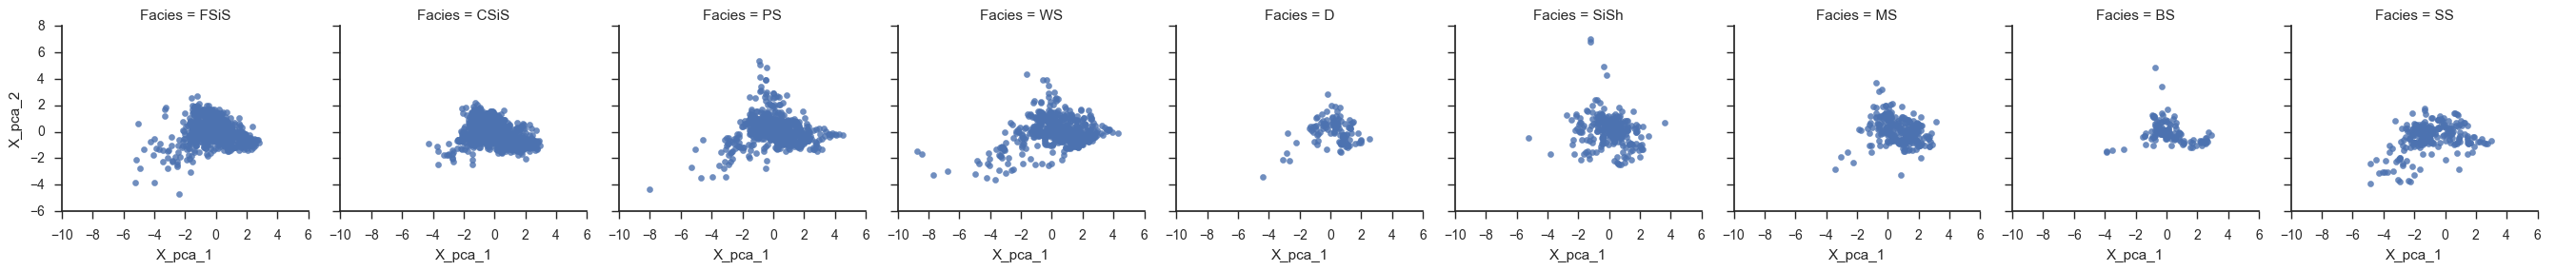

In [47]:
### Set some colour parameters.
cmap_facies = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
cmap_m_nm = ["sage", "royalblue"]
cmap_clas_carb = ["gold", "slategrey"]

##### Principal Component Analysis #####

# Drop well name and binary features
drop = ["Well Name", "NM_M", "Depth", "Formation"]
X_temp = X
X_temp = X.drop(drop, 1)

# Data should be preprocessed using mean normalisation before input to principal component analysis. 
# After mean normalization each parameter should have zero mean. (mean=0 and variance=1).
from sklearn.preprocessing import normalize, StandardScaler, RobustScaler
#X_Scaler = StandardScaler()
X_Scaler = RobustScaler()
X_Scaled = X_Scaler.fit_transform(X_temp)

# Project onto the linear subspace spanned by k number of vectors.
K = 2 # K is called number of n_components in Sci Kit learn.
from sklearn.decomposition import PCA, IncrementalPCA
ipca = IncrementalPCA(n_components=K, batch_size=10)
X_ipca_K2 = ipca.fit_transform(X_Scaled)

# Choose K by looking to retain 99% (0.01) of variance. K should be the smallest value that will give a 99% variance.
# There can be some variations for example 95% (0.05).
cum_var_exp = np.cumsum(ipca.explained_variance_ratio_)
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range((ipca.n_components_)), ipca.explained_variance_ratio_, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(ipca.n_components_), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    
            ####### Plots ########
    
## Make a data frame using the 2 dimensional result from principal component analysis
df_ipca = pd.DataFrame(X_ipca_K2, columns=["X_pca_1", "X_pca_2"])
df_ipca = df = pd.concat([new_classes, df_ipca], axis=1)
with sns.axes_style("white"):
    sns.jointplot(x="X_pca_1", y="X_pca_2", data=df_ipca, kind="hex", color="k");
sns.set(style="ticks")

facies_colors = ['#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D', '#F4D03F']
cmap=facies_colors
pal_facies=sns.color_palette(cmap)

def pca_plot(List):
    for i in List:
        Lithology_pca = sns.FacetGrid(df_ipca, col=i, palette=pal_facies, hue="Facies")
        Lithology_pca.map(plt.scatter, "X_pca_1", "X_pca_2", alpha=.3)
        Lithology_pca.add_legend();

### Plot facies split against different categories ###
List = ["Lithology", "Dep Environment", "M vs NM"]
pca_plot(List)

### Plot all facies ###
Facies = sns.FacetGrid(df_ipca, col="Facies", palette=pal_facies)
Facies.map(plt.scatter, "X_pca_1", "X_pca_2", alpha=.8)
Facies.add_legend();

## Reproducibility and result

In [138]:

###### Define a set of functions to run the evaluation #######

def Start_up():
    ######## Initalize and load file ##########
    import matplotlib.pyplot as plt
    import pandas as pd 
    import numpy as np
    import sys #only needed to determine Python version number
    import matplotlib #only needed to determine Matplotlib version number
    import seaborn as sns

    #Enable inline plotting
    %matplotlib inline

    print ("This has been run using:")
    print('Python version ' + sys.version)
    print('Pandas version ' + pd.__version__)
    print('Matplotlib version ' + matplotlib.__version__)

    ## Set colour template
    sns.set(style="ticks")    ## Set style to white background and ticks
    sns.set_context("paper")   ## Set size of labels

    try:
        print("Loading dataset...")
        CSV_Dataset = r"facies_vectors.csv"
        Dataset = pd.read_csv(CSV_Dataset)
    except:
        print ("An error has occured")
        print ("Please ensure that you have downloaded the dataset and")
        print ("entered the file location and file path for your machine")
    finally:
        print ("Expected input is the file facies_vectors.csv")

    return Dataset

######## Prepare X and y ############
    
def prepare_X_Y(Dataset):
    ## Remove Recruit F9
    Dataset = Dataset[Dataset["Well Name"] != "Recruit F9"]
    Dataset = Dataset[Dataset["Well Name"] != "Cross H Cattle"]
    Dataset = Dataset[Dataset["Facies"] != 9]

    print (Dataset.describe())
    ## Replace all missing values with the mean values
    Dataset = Dataset.fillna(Dataset.mean())

    ytemp = Dataset.iloc[:,0] #Note 0 index is used in python for the first position. 
    #print (("m={0}").format(ytemp.shape))

    ## Keep the original version where all classifiers are stored in one columnn
    y_one_column = ytemp

    ## One hot vector for each valye of y. In case this is to be used as input for OneVsRest
    ## Get all the elements of y
    ySet = set(ytemp)
    Yn = len(ySet)
    #print (("K={0}").format(Yn))

    # Each classifier should have a sperate column and be measured only in ones and zeros
    one_hot_y = ytemp
    y = pd.get_dummies(one_hot_y)
    y = y.rename(columns={1: "NM Coarse Sandstone", 2: "NM Coarse Siltstone", 3: "NM Fine Siltstone", 4:"Marine Siltstone", 5:"Mud Stone", 6:"Wacke Stone", 7:"Dolomite", 8:"Packe Stone", 9:"Baffle Stone"})
    
    [Dm , Dn] = Dataset.shape
    X = Dataset.iloc[:,1:Dn]  #where Dn is the number of columns in the original dataset
    
    ## X, y (One hot vector version), y (flat including intergers from 1-9).
    return X, y, y_one_column

######### Feature Engineering ########

def prepare_X(X):
    ## List which features should be dropped from the training data
    Dropped_Features = ["Formation"]

    X = X.drop(Dropped_Features, 1)
    [Xm , Xn] = X.shape

    ## Merge together new class labels, y results as one hot vecotr and X
    df_full = pd.concat([y, X], axis=1)
    df = pd.concat([X], axis=1)

    ## Remove the well name
    X= X.drop(["Well Name"],1)

    ## Feature engineering. All features have shown importance in PCA
    ## Take advantage of this by creating new features based on the relationships of key featuers.
    ## Make relationships between key features
    
    X["DeltaPHI_PHIND"]=(X["DeltaPHI"]*X["PHIND"])
    X["GR_PE"]=(X["GR"]*X["PE"])
    X["PHIND_PE"]=(X["PHIND"]*X["PE"])
    X["DeltaPHI_PE"]=(X["DeltaPHI"]*X["PE"])
    X["ILD_log10_PE"]=(X["ILD_log10"]*X["PE"])
    X["DeltaPHI_PHIND2"]=(X["DeltaPHI"]/X["PHIND"])
    X["GR_ILD_log10"]=(X["GR"]*X["ILD_log10"])
    X["M_PE"]=(X["NM_M"]*X["PE"])
    X["GR_PHIND"]=(X["GR"]*X["PHIND"])
    X["GR_DeltaPHI"]=(X["GR"]*X["DeltaPHI"])
    X["ILD_log10_PHIND"]=(X["ILD_log10"]*X["PHIND"])
    X["ILD_log10_DeltaPHI"]=(X["ILD_log10"]*X["DeltaPHI"])
    X["PHIND_PE2"]=(X["PHIND"]/X["PE"])
    X["DeltaPHI_PE2"]=(X["DeltaPHI"]/X["PE"])

    
    ###### Make new features out of linear trends of key features ###### 
    
    def make_linear_features(X):
        def Linear_regression_features(a,b):
            from sklearn.linear_model import LinearRegression
            LinReg = LinearRegression()
            LinReg.fit(a,b)
            f_lin = LinReg.predict(a) 

            return f_lin

        In1 = [X["PE"], X["PE"], X["PHIND"]]
        In2 = [X["PHIND"], X["ILD_log10"], X["ILD_log10"]]    

        m = 0
        for i in In1:
            a = i
            b = In2[m]
            [l,]=a.shape
            a=a.values.reshape((l,1))
            b=b.values.reshape((l,1))
            f_lin = Linear_regression_features(a,b)
            X["f_lin"+str(m)]=f_lin
            m+=1

        return X

    make_linear_features(X)

    return X

########## ######### ###########

def X_y_inputs(X, y):
    X = X
    y = y
    return X, y


def select_scaler(Scaler_name):
    
    if Scaler_name == "Robust":
        from sklearn.preprocessing import RobustScaler
        Scaler = RobustScaler()
    
    elif Scaler_name == "Standard":
        from sklearn.preprocessing import StandardScaler
        Scaler = StandardScaler(with_mean=False)
    
    return Scaler


def inner_loop_cv(cv_name, n):
    
    if cv_name == "KFold":
        from sklearn.model_selection import KFold
        cv = KFold(n_splits=n, shuffle=False)
    
    elif cv_name == "StratifiedKFold":
        from sklearn.model_selection import StratifiedKFold
        cv = StratifiedKFold(n_splits=n, shuffle=False)
    
    return cv


def select_estimator(model_name):

    ## XGB
    if model_name == "XGB":
        import xgboost as xgb
        from sklearn.multiclass import OneVsRestClassifier
        xgb = xgb.XGBClassifier(gamma=0.05, subsample = 0.7, colsample_bytree = 0.9, min_child_weight = 1, max_depth = 3)
        estimator = xgb
        #estimator = OneVsRestClassifier(xgb)
        scores = ["f1_macro"]
        parameters = [{ 
                       "gamma":[0.05, 0.1, 0.3, 0.5, 0.7], 
                       "max_depth":[2, 3, 4, 5, 6, 7, 8],
                       "min_child_weight":[1], 
                       "subsample":[0.7, 0.8], 
                       "colsample_bytree":[0.9]}]
        
    return estimator, scores, parameters


def optimise_parameters(X, y, estimator, scores, cv, parameters):
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import classification_report
    Full_dict = {}
    best_result_list = []
    for score in scores:
        clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=cv,
                           scoring=score)
        
        ## Fit the model
        clf.fit(X, y)
        
        ## Store the best parameters
        result = clf.best_params_
        best_result_list.append(result)
        
        ## Capture all results data as a dataframe and store in a dictionary
        Full_dict[str(score)]=(pd.DataFrame(clf.cv_results_))

        Best_Estimator = clf.best_estimator_
        
        print ("Best classifier score:", clf.best_score_, ":", clf.best_params_)
        
    return best_result_list, Full_dict, Best_Estimator, clf

### K fold split
def train_Kfold(X, y, slice):
    train_index=(train_list[part])
    cv_index=(cv_list[part])

    X_tr=X.iloc[train_index]
    y_tr=y.iloc[train_index]

    X_cv=X.iloc[cv_index]
    y_cv=y.iloc[cv_index]

    X_tr=X_tr.values
    y_tr=y_tr.values
    X_cv=X_cv.values
    y_cv=y_cv.values

    ######  Scale the training and cross validation data ######
    Scaler = select_scaler(Scaler_name)
    X_tr = Scaler.fit_transform(X_tr)
    X_cv = Scaler.fit_transform(X_cv)
    
    return X_tr, X_cv, y_tr, y_cv

### Code taken from other entries to make a well log display ###
def make_facies_log_plot(logs, facies_colors):
    
    #### Import to make def well plots work ####
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.colors as colors
    import matplotlib as mpl
    
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Predicted_y'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Predicted_y')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

In [139]:
Dataset = Start_up()

#########    ############
##### Paramerters #######
Scaler_name ="Standard"
model_name = "XGB"
cv_name = "KFold"
n=4 # number of splits
#########    ############
########## ##############

## Prepare X and y
X, y, y_one_column = prepare_X_Y(Dataset)

## Feature engineering
Input_X = prepare_X(X)

## Test model
# 0.
X, y = X_y_inputs(Input_X, y_one_column)
# 1.
Scaler = select_scaler(Scaler_name)
X = Scaler.fit_transform(X)
# 2.
estimator, scores, parameters = select_estimator(model_name)
# 3.
cv = inner_loop_cv(cv_name, n)
# 4.
best_result_list, Full_dict, Best_Estimator, clf = optimise_parameters(X, y, estimator, scores, cv, parameters)
#### Results in the best classifier being transfered to be fitted in the next cell ####

This has been run using:
Python version 3.5.2 |Anaconda custom (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
Pandas version 0.19.1
Matplotlib version 1.5.3
Loading dataset...
Expected input is the file facies_vectors.csv
            Facies        Depth           GR    ILD_log10     DeltaPHI  \
count  3964.000000  3964.000000  3964.000000  3964.000000  3964.000000   
mean      4.293391  2900.946393    65.925832     0.662245     4.560130   
std       2.328107   132.814458    30.012673     0.248731     5.275988   
min       1.000000  2573.500000    10.149000    -0.025949   -21.832000   
25%       2.000000  2816.000000    47.716750     0.502000     1.800000   
50%       3.000000  2926.500000    66.009500     0.639000     4.464500   
75%       6.000000  3000.000000    80.060750     0.823000     7.647250   
max       8.000000  3138.000000   361.150000     1.800000    19.312000   

             PHIND           PE         NM_M       RELPOS  


F1 score: 0.804919645415


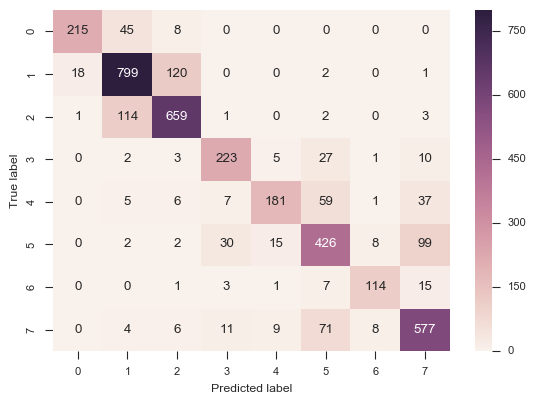

In [140]:
p_y=clf.predict(X)

#### Print Score ####

from sklearn.metrics import f1_score
print ()
print ("F1 score:", f1_score(y, p_y, average="weighted"))

#### Make Confusion Matrix ####

from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y, p_y)
sns.heatmap(cnf_matrix, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')

## Make prediction on test data

In [141]:
##### Load test data #####
df_test = pd.read_csv('validation_data_nofacies.csv')

#### Feature Engineering #####
X = prepare_X(df_test)

#### Scale X for test data ####
Scaler = select_scaler(Scaler_name)
X = Scaler.fit_transform(X)

#### Predict y on the test data ###
p_y=clf.predict(X)

#### Merge predicted y with the test data ####
df_test_result=df_test
df_test_result["Predicted_y"]=p_y

#### Save results to a csv file ####
df_test_result.to_csv("ADMC_Prediction_XGB_4")
df_test_result.head()

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Predicted_y
0,A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000,2
1,A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956,3
3,A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933,3
4,A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911,3


## Visualise results

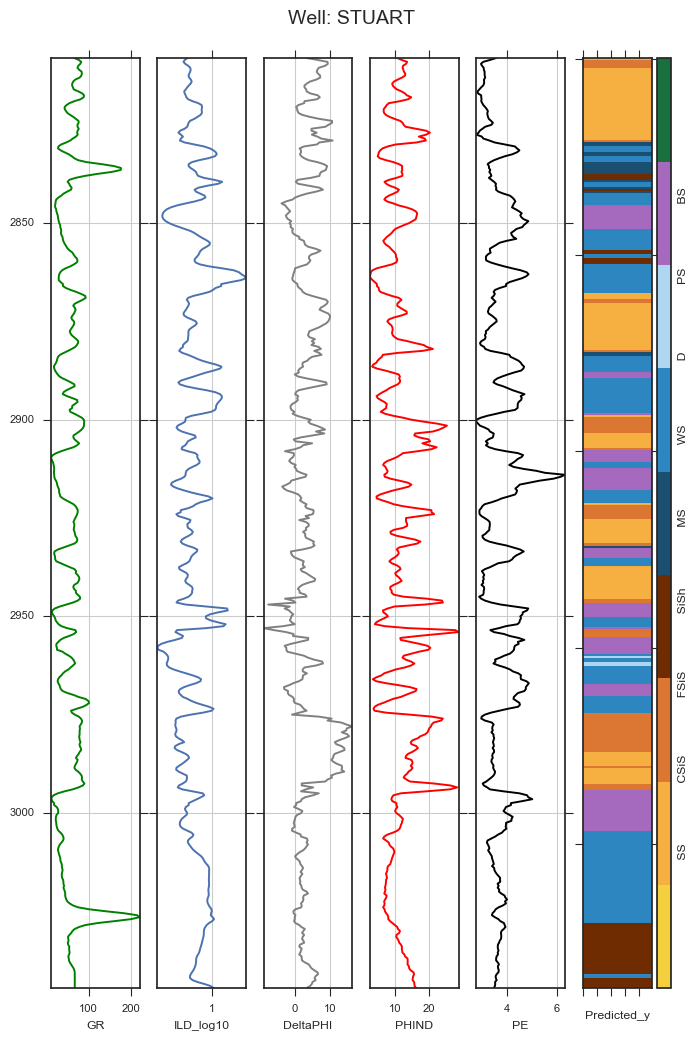

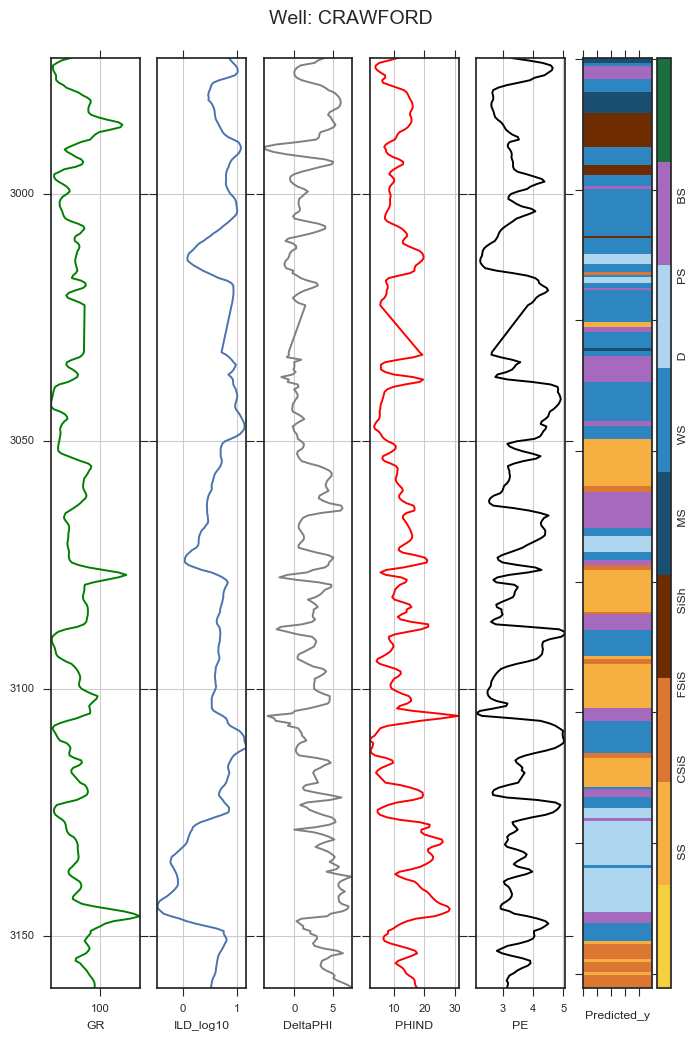

In [142]:
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

##### Plot result Wells ####
make_facies_log_plot(
    df_test_result[df_test_result['Well Name'] == 'STUART'],
    facies_colors)

make_facies_log_plot(
    df_test_result[df_test_result['Well Name'] == 'CRAWFORD'],
    facies_colors)